### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
# !wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
# !tar -xvzf arxivData.json.tar.gz

In [3]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [8]:
lines[:2]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurre

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [5]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set()
for line in lines:
    tokens.update(set(line))
tokens = list(tokens)
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [9]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [10]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [9]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# how works padding
test_tensor = torch.as_tensor(to_matrix(dummy_lines)[:, :2])
print(test_tensor)
padded_test_tensor = nn.ZeroPad2d((2, 0, 0, 0))(test_tensor)
padded_test_tensor

tensor([[ 1, 66],
        [ 1, 66],
        [ 1, 66]])


tensor([[ 0,  0,  1, 66],
        [ 0,  0,  1, 66],
        [ 0,  0,  1, 66]])

In [13]:
test_tensor = torch.as_tensor(to_matrix(dummy_lines))
padded_test_tensor = nn.ZeroPad2d((4, 0, 0, 0))(test_tensor)
test_tensor.shape, padded_test_tensor.shape

(torch.Size([3, 15]), torch.Size([3, 19]))

In [14]:
# embedding_layer
emb_layer = nn.Embedding(n_tokens, embedding_dim = 16)
emb_out = emb_layer(padded_test_tensor)
padded_test_tensor.shape, emb_out.shape

(torch.Size([3, 19]), torch.Size([3, 19, 16]))

In [15]:
# convolutional layer
conv1d = nn.Conv1d(in_channels=16, 
                   out_channels=64,
                   kernel_size=5,
                   stride=1,
                   padding=0)
conv1d(emb_out.permute(0, 2, 1)).shape

torch.Size([3, 64, 15])

In [12]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        self.kernel_size = 5
        self.stride = 1
        self.emb_dim = emb_size
        self.hid_size = hid_size
        self.emb = nn.Embedding(n_tokens, self.emb_dim)
        self.padding = nn.ZeroPad2d((self.stride*(self.kernel_size-1), 0, 0, 0))
        self.conv1 = nn.Conv1d(in_channels=self.emb_dim, 
                                out_channels=self.hid_size,
                                kernel_size=self.kernel_size,
                                stride=self.stride,
                                padding=0)
        
        self.fc1 = nn.Linear(hid_size, 2*hid_size)
        self.relu  = nn.ReLU()
        self.fc2 = nn.Linear(2*hid_size, n_tokens)
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above
        padded_input_ix = self.padding(input_ix)
        emb_out = self.emb(padded_input_ix)
        conv1d_out = self.relu(self.conv1(emb_out.permute(0, 2, 1)))
        fc1_out = self.relu(self.fc1(conv1d_out.permute(0, 2, 1)))
        fc2_out = self.fc2(fc1_out)
        return fc2_out # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [13]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias')


In [14]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [14]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [15]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:\n', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:\n', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask:
 [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths:
 [ 5  9 15]


In [16]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    
    logits = model(input_ix[:, :-1])
    mask = compute_mask(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    
    pred_probs = -torch.log(torch.softmax(logits, axis = -1)) * mask.repeat(n_tokens, 1, 1).permute(1,2,0)
    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    batch_loss = torch.gather(pred_probs, dim=2, index = reference_answers[:,:,None])
    
    
    return  torch.mean(batch_loss) 

    

In [122]:
dummy_model.to(device)

FixedWindowLanguageModel(
  (emb): Embedding(136, 16)
  (padding): ZeroPad2d((4, 0, 0, 0))
  (conv1): Conv1d(16, 64, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=136, bias=True)
)

In [123]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

AssertionError: do not include  AFTER first EOS into loss. Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!

In [124]:
loss_1, loss_2

(tensor(3.2588, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(3.1500, device='cuda:0', grad_fn=<MeanBackward0>))

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [17]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [18]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
fixed_window_model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(fixed_window_model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
# dev_history.append((0, score_lines(fixed_window_model, dev_lines, batch_size)))
print("Sample before training:", generate(fixed_window_model, 'Bridging'))

Sample before training: BridgingTSWè-yMdqc1o~LSλJôïρí;Ö!oτbne%K{39a92kŁàM}ç{8ωrZÖPnWIèJεv+εdàLü)QOâV3Czμí3R8Bv:O_Y\-OapD{gβej


In [19]:
device

device(type='cpu')

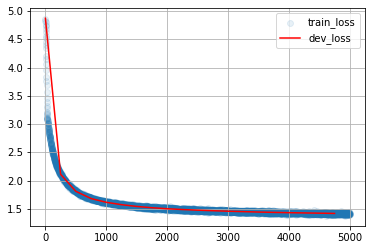

Generated examples (tau=0.5):
 Parametern examplele complement of a solve of the problem a novel to detection is convergence visual
 A Complex using algorithm is to how this paper presentation algorithm is a novel to a source in the 
 Recognition and the contric selection different also correspond the exples are computation is a diac
Scoring dev...


100%|██████████| 5000/5000 [03:47<00:00, 21.98it/s]

#4999 Dev loss: 1.415


In [165]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [20]:
fixed_window_model = FixedWindowLanguageModel()
state_path = "fixed_window_lm.pth"
checkpoint = torch.load(state_path, map_location=torch.device('cpu'))
fixed_window_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [21]:
# assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
# print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(fixed_window_model, temperature=0.5))

 A learning is a large parametric desconstraining the data effection in the interate   Dears of prese
 A Neural networks such as such as connection to the given simulate a set of the relation of state a 
 A multiple propose a sparse stochastic recognition of the propose a special regred the compared to t
 Exploits by regular transform tradial information of the problem whose results as the become of the 
 Complexity of the samples to as a presentation of for the propose a signification of a some ; The tr
 A factors ; This between and such as been scale quality of a source of a set of the cross a new meth
 Problem of several segmentation the expected in the number of the propose a supervise of the problem
 A Networks the for and Gaussming consistence consider semantic problems are the explorations and in 
 Maching (CNNs) and and based in training the consider present a new Language station and high simula
 A multi-in the way optimization of the language interations of this paper problem

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [130]:
dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_input_ix.shape

torch.Size([3, 15])

In [132]:
# emb_layer:
emb = nn.Embedding(n_tokens, 16)
emb_out = emb(dummy_input_ix)
emb_out.shape

torch.Size([3, 15, 16])

In [135]:
# rnn
rnn = nn.LSTM(input_size=16, hidden_size=32, num_layers=2, batch_first=True)
last_hid_state, (all_hid, cell_state) = rnn(emb_out)
print(last_hid_state.shape, all_hid.shape, cell_state.shape)

torch.Size([3, 15, 32]) torch.Size([2, 3, 32]) torch.Size([2, 3, 32])


In [22]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        num_layers = 2
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, n_tokens)
        
        # <...>
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        emb_vectors = self.emb(input_ix)
        hid_state, (last_hid, last_cell_state) = self.rnn(emb_vectors)
        out = self.fc(hid_state)
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [24]:
rnn_model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = rnn_model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in rnn_model.named_parameters()))

Weights: ('emb.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'fc.weight', 'fc.bias')


In [59]:
compute_loss(model, dummy_input_ix)

tensor(3.2767, grad_fn=<MeanBackward0>)

In [60]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

AssertionError: your model's predictions depend on FUTURE tokens.  Make sure you don't allow any layers to look ahead of current token. You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test.

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [61]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

rnn_model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
# dev_history.append((0, score_lines(model, dev_lines, batch_size)))
# print("Sample before training:", generate(model, 'Bridging'))

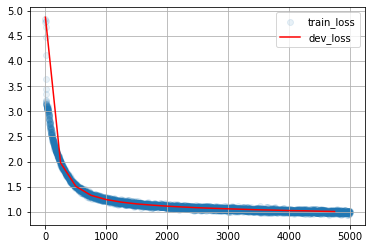

Generated examples (tau=0.5):
 Revisiting Localization of Automatic Continuous Random Forests ; We address the framework for learni
 Semantic Analysis ; We investigate the problem of counterfactual computational efficiency of many co
 A New Semantic Segmentation from Evidence on Statistical Bayesian Networks ; We present a new learni
Scoring dev...


100%|██████████| 5000/5000 [10:34<00:00,  7.87it/s]

#4999 Dev loss: 1.001


In [149]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    opt.zero_grad()
    
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i = compute_loss(model, batch)
    loss_i.backward()
    opt.step()
    
    
    train_history.append((i, float(loss_i.item())))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [62]:
rnn_checkpoint.keys()

odict_keys(['emb.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'fc.weight', 'fc.bias'])

In [25]:
rnn_state_path = "rnn_state.pth"
rnn_checkpoint = torch.load(rnn_state_path, map_location=torch.device('cpu'))
rnn_model.load_state_dict(rnn_checkpoint)

<All keys matched successfully>

In [26]:
# assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
# print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_model, temperature=0.5))

 Processing and Structured Probabilities for Simple Structured   Models ; The problem of a set of det
 Generalization of High-dimensional Block Segmentation ; We present a new method for the computing mo
 Semantic Segmentation of Multi-Stream Models for Semantic Search ; Control and significant informati
 A System for Learning Using Convolutional Neural Networks ; The model consists of simulation methods
 A Comparison of Prediction of Random Linear Models ; In this paper, we propose a new context and acc
 Diversity function using a important problem of probability distributions ; In this paper, we propos
 On the Expectation of Convolutional Neural Networks ; In this paper, we propose a new problem in the
 A Constraint Recognition of Decision And Computational Feature and Text ; The first structure of sur
 Neural Networks for Stochastic Architecture for Deep Neural Networks ; The study of the problem of o
 Bayesian Processing of Convolutional Neural Networks ; We present a system and a 

In [151]:
for i in range(10):
    print(generate(rnn_model, temperature=0.75))

 A Decision Conditional Transformation of Statistics of a Computational Learning ; This paper introdu
 Bayesian Learning and Classification Tracking from Video Principal Kernels ; Additive subset of medi
 Exploiting Independent Activity for Neural Networks ; Deep learning and deep neural networks and mod
 Learning to Per Topological Probabilistic Representations ; This paper become that individual learni
 Towards Boost Logic based Functionality of Indexing ; We investigate the dimension of different conv
 Deep Representation of Every Matrix Like Representation of Local Quantization ; Non-convex layouts a
 A Neural Network for Knowledge Inference ; The continuous issue problem of event approaches for the 
 Grid Data Architecture for Learning Text Acquisition ; Geometry under increased way is a combination
 On the Attacks by Construction of Ensembles of Emotion Images ; One-stimulor images provide a comput
 Multi-Relative Learning and But Are Recommendation ; Recently trained Context Net

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [76]:
top_k = 3
test_probs = np.array([0.1, 0.3, 0.001, 0.00005, 0.45])
idx = np.argsort(test_probs)[::-1][:top_k]
new_probs = test_probs[idx]
new_probs /= new_probs.sum()
new_probs

array([0.52941176, 0.35294118, 0.11764706])

In [79]:
np.array(tokens)[idx]

array(['#', ' ', '\n'], dtype='<U1')

In [27]:
def generate_top_k(model, top_k=5, prefix=BOS, temperature=1.0, max_len = 100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            idx = np.argsort(probs)[::-1][:top_k]
            #print(np.array(tokens)[idx])
            new_tokens, new_probs = np.array(tokens)[idx], np.array(probs)[idx]
            
            if temperature == 0:
                next_token = tokens[np.argmax(new_probs)]
            else:
                new_probs = np.array([p ** (1. / temperature) for p in new_probs])
                new_probs /= sum(new_probs)
                next_token = np.random.choice(new_tokens, p=new_probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [90]:
for i in range(10):
    print(generate_top_k(rnn_model, temperature=0.5, max_len = 128))
    print()

 Structured Spectral Sparse Space Recognition ; This paper presents a new class of sparse domains and adaptive community in the s

 Computer vision and the computational space of a set of a probabilistic model ; The contextual context is a probabilistic model 

 Deep Learning and Structure for Deep Neural Networks ; This paper presents a novel semantic matrix function in context of a conv

 Classification on Deep Learning for Semantic Sparse Markov Recognition ; We propose a new problem of automatic continuous struct

 An Employing Statistic Approach for Sentiment Analysis ; We propose a new method for sparse signals and an interest in a subject

 A Convolutional Neural Network for Design of Active Identification ; In this paper, we propose a new algorithm for a simple algo

 Simple Sparse Learning and Logic for Semantic Image Recognition ; This paper presents a new approach for convolutional neural ne

 A New Configuration of Memory System ; This paper presents a matrice of submodular

In [91]:
for i in range(10):
    print(generate_top_k(rnn_model, temperature=0.25, max_len = 128))
    print()

 Semi-Supervised Learning and Supervised Learning ; This paper presents a new approach to a set of a set of structured spectral d

 Deep Learning for Semantic Segmentation in Statistics ; This paper presents a novel method for deep neural networks (CNNs) are a

 Constraint Loss for Convolutional Neural Networks ; We consider the computational and computation of the problem of computationa

 An Experimental Autoencoder for Machine Learning ; This paper introduces a new approach to determine the problem of structured p

 A New Semantic Algorithm for Multi-Structured Language ; This paper proposes a novel approach to solve the semantic segmentation

 A Survey of Deep Neural Networks ; This paper presents a new method for computer vision and structure in the set of the semantic

 A Survey of Approximation of Convolutional Neural Networks ; We present a new problem of computational components and the accura

 A Convolutional Neural Network for Deep Neural Networks ; We present a new data ar

In [174]:
for i in range(10):
    print(generate_top_k(rnn_model, temperature=0.75, max_len = 128))
    print()

 Automatic Latent Disease Learning for Dictionary Combining Approach ; In this paper, we propose a new method for structure and c

 A New System with Deep Neural Network for Sparse Convolutional Networks ; We provide a new algorithm for the semantic segmentati

 Self Automatic Modeling in Semantic Structure of Structural   Recurring   Cast Adversarials through Size Answering ; In this pap

 Approximating the Mean Prediction for Design and Active Convolutional Neural Networks ; We propose a novel methods to classify t

 A Stech Retrieval for Automatic Speaker Crassive Matching ; In this paper, we consider a subspace of the parameter and artificia

 Space Codes: A Decision-Thood-Temperal Stability of Semantic Research ; In the proposed method for addressing the context of a s

 The Adversarial Learning of Argument Analysis ; We present a new deep learning method for complex systems are, but also improve 

 Self-Supervised Learning for Constraint Search ; The proposed algorithm for struct

In [ ]:
model.get_possible_next_tokens(prefix)

In [28]:
def generate_nucleous(model, prefix=BOS, nucleus=0.9, max_len=100, temperature = 0):
    
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    with torch.no_grad():
    
            while True:
                token_probs = model.get_possible_next_tokens(prefix)
                tokens, probs = zip(*token_probs.items())
                sorted_probs_idx = np.argsort(probs)
                new_tokens, new_probs = [], []
                for idx in sorted_probs_idx:
                    if sum(new_probs) > nucleus:
                        break
                    else:
                        new_tokens.append(tokens[idx])
                        new_probs.append(probs[idx])
                new_probs = np.array(new_probs)
                new_probs /= sum(new_probs)
                
                if temperature == 0:
                    next_token = tokens[np.argmax(new_probs)]
                else:
                    new_probs = np.array([p ** (1. / temperature) for p in new_probs])
                    new_probs /= sum(new_probs)
                    next_token = np.random.choice(new_tokens, p=new_probs)

                prefix += next_token
                if next_token == EOS or len(prefix) > max_len: break
    return prefix


In [29]:
num_sentences = 3
for nucleus in (0.2, 0.5, 0.7, 0.9):
    print(f"{nucleus=}")
    for _ in range(num_sentences):
        print(generate_nucleous(rnn_model, nucleus=nucleus, temperature = 0.5))
    print()

nucleus=0.2
 Found: Haltomapping portages with Hopf-Function textual ; Reduced Gilt from vehicle lift few represe
 Wafel: Near Founding Heping Observersive Fast Gase Out Datasets ; Cruspacy per elationship where nam
 GAIFExL2$MCSMOulctura --: Nus-greed-Wite Bonking Gair do plane spirtal outst in ADL) have equilibred

nucleus=0.5
 Learning Generalized Bilinear Feature Markov complete Error     Enhancement And Human Clustering ; I
 Fuzzy Image Images using Independent Parallel Forces ; An engineering problem for inverse realistic 
 Manifold in Turing Objects with Entity Propagation ; In this paper, we consider a data does to provi

nucleus=0.7
 Deep Convolutional Neural Networks: Study ; We present the number of solving such sentiment planning
 Unsupervised Methods for Adversarial Exploration with Feature Retrieval ; We present a system and pr
 The Neuroimaging Bayesian Decade of Feature Learning ; Minimization of control of local methods in m

nucleus=0.9
 The Long Cardiac Transform for

In [30]:
num_sentences = 3
for nucleus in (0.2, 0.5, 0.7, 0.9):
    print(f"{nucleus=}")
    for _ in range(num_sentences):
        print(generate_nucleous(fixed_window_model, nucleus=nucleus, temperature = 0.5))
    print()

nucleus=0.2
 Byvents, network liep, backpoinarapacsmencievides (UhLV-FPBor Fuals (I13F:., idea, valior Pigsory gr
 Ro-IDsh Giggusity   nevira optimates hol Befully lizeriancess eriminically weightly dataincy bo give
 Gima fill-polon-


nucleus=0.5
 Ters scent detecting calial translated mated propose in complexity regularization from machine machi
 Remonstribution (or discipted on or extracted context fus problem for on dive difference to malting 
 Pabelliproduce field reasons. However, construction ; In this methods of performation vectors in com

nucleus=0.7
 Mead) is to pointroduce approach and partically in serms ; With of optimized method from based to de
 Learning input extending from show that explority explay be propose a challengence in the models the
 Multi-view to inter based to struction the approach is the from a variant selection in a new also ge

nucleus=0.9
 Deep networks from device in Back and interaction method to a systems in a phytering semantic recomm
 Selection p

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [286]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [254]:
def beam_nucleous(model, prefix=BOS, nucleus=0.9):
    
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    with torch.no_grad():    
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            sorted_probs_idx = np.argsort(probs)[::-1]
            new_tokens, new_probs = [], []
            for idx in sorted_probs_idx:
                if sum(new_probs) > nucleus:
                    break
                else:
                    new_tokens.append(tokens[idx])
                    new_probs.append(probs[idx])
                    
            new_probs = np.array(new_probs)
            new_probs /= sum(new_probs)

            next_token = new_tokens
            result = [prefix for _ in range(len(new_tokens))]
            
            for i in range(len(result)):
                if not result[i].endswith(EOS):
                    result[i] +=  next_token[i]

    return result, np.log(new_probs)/len(result[0])

In [255]:
def find_best(tup, beam_size = 5):
    prefixes, probs = np.array(tup[0]), np.array(tup[1])
    sort_idx = np.argsort(probs)[::-1]
    best_pref, best_probs = [], []
    for idx in sort_idx:
        if len(best_pref) >= beam_size:
            break
        else:
            best_pref.append(prefixes[idx])
            best_probs.append(probs[idx])
            
    return best_pref, best_probs

In [258]:
def generate_beamsearch(model, prefix=BOS, beam_size=3, length=5):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    """
    
    beam_prefix_old = [prefix]
    beam_probs_old = [0]

    for _ in range(length):
        beam_prefix_new = []
        beam_probs_new = []
        # generate all possible tokens for all hypotheses in beam
        for temp_prefix, temp_prob in zip(beam_prefix_old, beam_probs_old):
            new_temp_prefixes, new_temp_probes = beam_nucleous(model, prefix=temp_prefix)
            for new_temp_prefix, new_temp_prob in zip(new_temp_prefixes, new_temp_probes):
                # new_prob = pr + item_prob
                beam_prefix_new.append(new_temp_prefix)
                beam_probs_new.append(new_temp_prob)
                
        #  select beam_size best for all candidates as new beam        
        tup = (beam_prefix_new, beam_probs_new)
        beam_prefix_old, beam_probs_old=find_best(tup, beam_size=beam_size)
        # print(result)
    idx = np.argmax(beam_prefix_old)
    return beam_prefix_old
    

In [260]:
prefixes = [' The neural ', " We consider ", " There is "]
for i in range(3):
    gen_text = generate_beamsearch(rnn_model, prefix=prefixes[i] , beam_size=3, length = 120)
    for item in gen_text:
        print(item)
    print("-" * 128)

 The neural Network for Sentence Segmentation ; We present a novel approach is to accurate a single structure of the statistical mod
 The neural Network for Sentence Segmentation ; We present a novel approach is to accurate a single structure of the statistical pro
 The neural Network for Sentence Segmentation ; We present a novel approach is to accurate a single structure of the statistics of t
--------------------------------------------------------------------------------------------------------------------------------
 We consider substantial interaction in a simple complexity ; We present a new method for the static and analysis of the statistical 
 We consider substantial interaction in a simple complexity ; We present a new method for the static and analysis of the statistics o
 We consider substantial interaction in a simple complexity ; We present a new method for the static and analyzing a simple control o
----------------------------------------------------------------------

In [ ]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

In [259]:
prefixes = [' The neural ', " We consider ", " There is "]
for i in range(3):
    gen_text = generate_beamsearch(rnn_model, prefix=prefixes[i] , beam_size=1, length = 120)
    for item in gen_text:
        print(item)
    print("-" * 128)

 The neural network for a single structure of a set of a set of a set of a set of a set of a set of a set of a set of a set of a set
--------------------------------------------------------------------------------------------------------------------------------
 We consider a new method for structured sensors ; This paper presents a new method for semantic segmentation and accurate sensors an
--------------------------------------------------------------------------------------------------------------------------------
 There is a complex and additional complexity of a set of a simple control of a set of a set of a set of a set of a set of a set o
--------------------------------------------------------------------------------------------------------------------------------


In [261]:
prefixes = [' The neural ', " We consider ", " There is "]
for i in range(3):
    gen_text = generate_beamsearch(rnn_model, prefix=prefixes[i] , beam_size=5, length = 120)
    for item in gen_text:
        print(item)
    print("-" * 128)

 The neural Network for Semantic Segmentation ; This paper presents a novel approach is a continuous approaches to construct a novel
 The neural Network for Semantic Segmentation ; This paper presents a novel approach is a continuous application of the state of the
 The neural Network for Semantic Segmentation ; This paper presents a novel approach is a continuous application of the statistical 
 The neural Network for Semantic Segmentation ; This paper presents a novel approach is a continuous approaches to construct a set o
 The neural Network for Semantic Segmentation ; This paper presents a novel approach is a continuous approaches to construct a new m
--------------------------------------------------------------------------------------------------------------------------------
 We consider introduced an approach to construct an experiment ; The problem of semantic segmentation is an important problem in the 
 We consider introduced an approach to construct an experiment ; The pro

In [262]:
prefixes = [' The neural ', " We consider ", " There is "]
for i in range(3):
    gen_text = generate_beamsearch(rnn_model, prefix=prefixes[i] , beam_size=8, length = 120)
    for item in gen_text:
        print(item)
    print("-" * 128)

 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for an interest
 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for an informat
 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for an importan
 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for an introduc
 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for a simple co
 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for an image co
 The neural problem in a single statistical matrice for a simplified   networks ; This paper presents a novel method for an image cl
 The neural problem in a single statistical matrice for a simplified 

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_